Basé sur l'article "[The KL-UCB algortihm for bounded stochastic bandits and beyond](https://arxiv.org/abs/1102.2490)" de **Aurélien Garivier** et **Olivier Cappé**.

In [17]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [18]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#Parameters for scenario 2
p = np.array([.99, .98, .96, .93, .90, .10, .06, .04]) #Bernoulli Parameters
# p = np.array([.95, .90, .80, .65, .45, .25, .15, .10])
# p = np.array([.90, .80, .70, .55, .45, .35, .20, .10])
rate = np.array([6, 9, 12, 18, 24, 36, 48, 54])
tp = np.multiply(p,rate)

K= p.shape[0] #Number of branches
delta= ( np.ones(K)*np.max(tp) ) - tp

T= 5000 #Time periods
runs = 10 #Number of iterations

print("Pi:",p)
print("delta:",delta)

Pi: [0.99 0.98 0.96 0.93 0.9  0.1  0.06 0.04]
delta: [15.66 12.78 10.08  4.86  0.   18.   18.72 19.44]


## KL-UCB

In [20]:
%%capture
gors = kl_ucb_policy.GORS(K, rate, klucb_upper=kl_ucb_policy.klucb_upper_bisection_with_l) #Optimal Graphical OptimalRate Sampling
total_rewards_list_gors = np.zeros((runs, T))
actions_list_gors = []
klucb = kl_ucb_policy.KLUCBPolicy(K, rate) #Original KL UCB
total_rewards_list_klucb = np.zeros((runs, T))
actions_list_klucb = []
start_time = time.time()

for run in range(runs):
    gors.reset()
    actions_gors = np.zeros((K, T), dtype=np.int)
    rewards_gors = np.zeros((K, T), dtype=np.float)
    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=np.int)
    rewards_klucb = np.zeros((K, T), dtype=np.float)
    for t in range(T):
        arm_gors = gors.select_next_arm(8)
        actions_gors[arm_gors, t] = 1
        rewards_gors[arm_gors, t] = np.random.binomial(1, p[arm_gors]) * rate[arm_gors]
        gors.update_state(arm_gors, rewards_gors[arm_gors, t] / rate[arm_gors])

        arm_klucb = klucb.select_next_arm()
        actions_klucb[arm_klucb, t] = 1
        rewards_klucb[arm_klucb, t] = np.random.binomial(1, p[arm_klucb]) * rate[arm_klucb]
        klucb.update_state(arm_klucb, rewards_klucb[arm_klucb, t] / rate[arm_klucb])

    cumulative_rewards_gors = np.cumsum(rewards_gors, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_gors = np.sum(cumulative_rewards_gors, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_gors[run, :] = np.copy(total_rewards_gors)
    actions_list_gors.append(np.copy(actions_gors))

    cumulative_rewards_klucb = np.cumsum(rewards_klucb, axis=1)
    total_rewards_klucb = np.sum(cumulative_rewards_klucb, axis=0)
    total_rewards_list_klucb[run, :] = np.copy(total_rewards_klucb)
    actions_list_klucb.append(np.copy(actions_klucb))

time_spent = time.time() - start_time

## Results

In [21]:
print("Time for KL-UCB (Newton), with T =", T, ", runs =", runs, ":", (time_spent), "seconds")

Time for KL-UCB (Newton), with T = 5000 , runs = 10 : 31.199035167694092 seconds


## Average total rewards

In [22]:
mean_total_rewards_gors = np.mean(total_rewards_list_gors, axis=0)
mean_total_rewards_klucb = np.mean(total_rewards_list_klucb, axis=0)
print("t & Reward (total) G-ORS :", t, mean_total_rewards_gors[t])
print("t & Reward (total) KL-UCB :", t, mean_total_rewards_klucb[t])

t & Reward (total) G-ORS : 4999 106090.8
t & Reward (total) KL-UCB : 4999 105321.6


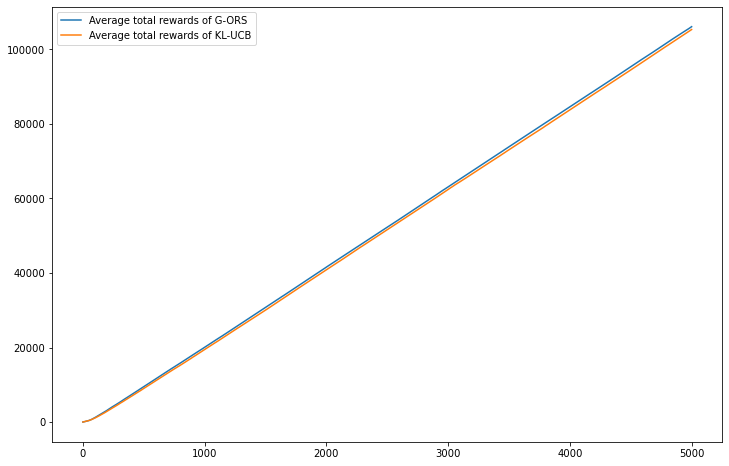

In [23]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(mean_total_rewards_gors, linestyle='-', label='Average total rewards of G-ORS')
ax1.plot(mean_total_rewards_klucb, linestyle='-', label='Average total rewards of KL-UCB')
ax1.legend(loc='best')
plt.show()

In [24]:
#Regrets calculation for G-ORS
total_action_gors = np.zeros((K, T))
for actions_gors in actions_list_gors:
    total_action_gors += np.cumsum(actions_gors, axis=1) #The cumulative times of each arm to be selected
total_action_gors = total_action_gors / runs
regret_cumule_gors = np.dot(delta, total_action_gors[:, :]) # Cumulative regrets
#Regrest calculation for KL-UCB
total_action_klucb = np.zeros((K, T))
for actions_klucb in actions_list_klucb:
    total_action_klucb += np.cumsum(actions_klucb, axis=1) #The cumulative times of each arm to be selected
total_action_klucb = total_action_klucb / runs
regret_cumule_klucb = np.dot(delta, total_action_klucb[:, :]) # Cumulative regrets

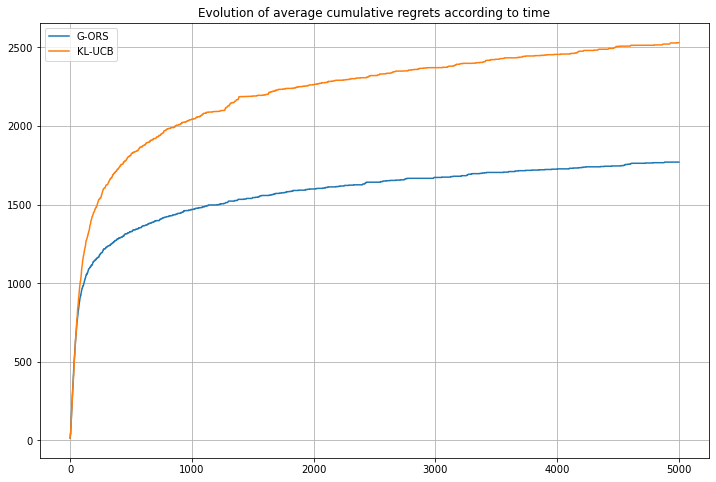

In [25]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_cumule_gors[:],linestyle='-', label='G-ORS')
ax1.plot(regret_cumule_klucb[:],linestyle='-', label='KL-UCB')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution of average cumulative regrets according to time')
#ax1.xscale('log')
plt.show()

## Distribution du regret

In [26]:
T0 = 4999

In [27]:
#G-ORS
distribution_regret_gors = []
distribution_regret_klucb = []
for actions_gors in actions_list_gors:
    distribution_regret_gors.append(np.dot(delta, np.sum(actions_gors[:, :T0], axis=1)))
for actions_klucb in actions_list_klucb:
    distribution_regret_klucb.append(np.dot(delta, np.sum(actions_klucb[:, :T0], axis=1)))

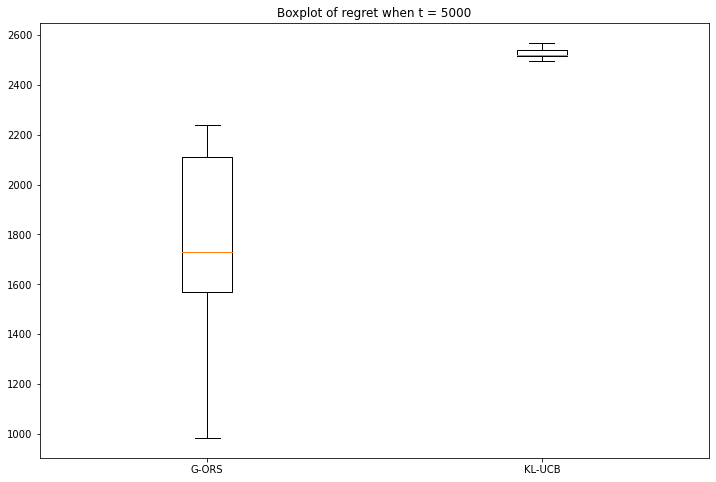

In [28]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_gors,
        distribution_regret_klucb
    ])
ax.set_xticklabels([
        'G-ORS',
        'KL-UCB'
    ])

ax.set_title('Boxplot of regret when t = 5000')
plt.show()